# ChEMBL Bioactivity data analysis for medicinal and non-medicinal plants

### Import modules

In [1]:
import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from utils import get_chembl_id, get_genus_and_family_info_for_plants
from collections import defaultdict

from ete3 import NCBITaxa
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare
from matplotlib_venn import venn2

tqdm.pandas()

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
DATA_DIR = '../data/'

# Load ChEMBL 32 bioassay data

In [4]:
assay_df = pd.read_csv(f'{DATA_DIR}/chembl32_biochem_assays.tsv.gz', sep='\t', compression='gzip')
assay_df.head(2)

,chembl_id,smiles,pchembl_value,assay_id
0,185983,c1cncc(CCCOc2ccc(-n3ccnc3)cc2)c1,8.96,CHEMBL615342
1,186402,CCOC(=O)N1CCN(CCOc2ccc(-n3ccnc3)cc2)CC1,7.80,CHEMBL615342


In [5]:
assay_df.chembl_id.nunique()

808163

# Load data

In [6]:
plant_chemical_df = pd.read_csv(
    f'{DATA_DIR}/plant_chemical_associations.tsv.gz',
    compression='gzip',
    sep='\t',
    usecols=[
        'plant_curie',
        'chemical_curie',
    ]
)
plant_chemical_df['cid'] = plant_chemical_df['chemical_curie'].str.split(':').str[1]
plant_chemical_df.head(2)

,plant_curie,chemical_curie,cid
0,ncbitaxon:1000425,pubchem.compound:3527,3527
1,ncbitaxon:1000425,pubchem.compound:68082,68082


In [7]:
plant_disease_df = pd.read_csv(
    f'{DATA_DIR}/plant_disease_associations.tsv.gz',
    compression='gzip',
    sep='\t',
    usecols=[
        'plant_curie',
        'disease_curie',
    ]
)

# Map CIDs to ChEMBL

In [8]:
if os.path.exists(f'{DATA_DIR}/chembl_mapper.json'):
    chembl_mapper = json.load(open(f'{DATA_DIR}/chembl_mapper.json'))
else:
    chembl_mapper = {}

c = 0

for cid in tqdm(plant_chemical_df.cid.unique()):
    if cid in chembl_mapper:
        continue

    c += 1

    chembl_id = get_chembl_id(cid)
    chembl_mapper[cid] = chembl_id

    if c == 10:
        json.dump(chembl_mapper, open(f'{DATA_DIR}/chembl_mapper.json', 'w'))
        c = 0
        
json.dump(chembl_mapper, open(f'{DATA_DIR}/chembl_mapper.json', 'w'))

100%|██████████| 87019/87019 [00:00<00:00, 814258.71it/s]


In [9]:
plant_chemical_df['chembl_idx'] = plant_chemical_df['cid'].map(chembl_mapper)
plant_chemical_df.head(2)

,plant_curie,chemical_curie,cid,chembl_idx
0,ncbitaxon:1000425,pubchem.compound:3527,3527,None
1,ncbitaxon:1000425,pubchem.compound:68082,68082,CHEMBL141690


In [10]:
plant_chemical_df.cid.nunique()

87019

In [11]:
med_plants = plant_disease_df.plant_curie.unique()
len(med_plants)

6048

In [12]:
medicinal_phytochemicals = set()
non_medical_phytochemicals = set()
non_mapped = set()

for plant_curie, chemical_idx, cid, chemical_idx in tqdm(plant_chemical_df.values):
    if chemical_idx is None:
        non_mapped.add(cid)
        continue

    if plant_curie in med_plants:
        medicinal_phytochemicals.add(chemical_idx)
    else:
        non_medical_phytochemicals.add(chemical_idx)

len(medicinal_phytochemicals), len(non_medical_phytochemicals), len(non_mapped)

100%|██████████| 383591/383591 [00:27<00:00, 13955.73it/s]


(13474, 11508, 67875)

# Subset ChEMBL bioassays for compounds of interest

In [13]:
# Fixing the chembl_id column
assay_df.chembl_id = 'CHEMBL' + assay_df.chembl_id.astype(str)  

In [14]:
phytochemicals = medicinal_phytochemicals.union(non_medical_phytochemicals)
mask = assay_df.chembl_id.isin(phytochemicals)
bioassays = assay_df[mask]
bioassays['active'] = np.where(bioassays['pchembl_value'] >= 6, True, False) 
bioassays.head(2)

,chembl_id,smiles,pchembl_value,assay_id,active
8,CHEMBL186433,CN(C)CCCCCCOc1ccc(-n2ccnc2)cc1,8.66,CHEMBL615342,True
17,CHEMBL35025,COc1ccc(CNC(=O)[C@@H](NC(=O)[C@H](NCc2cc(OC)c(...,7.30,CHEMBL615352,True


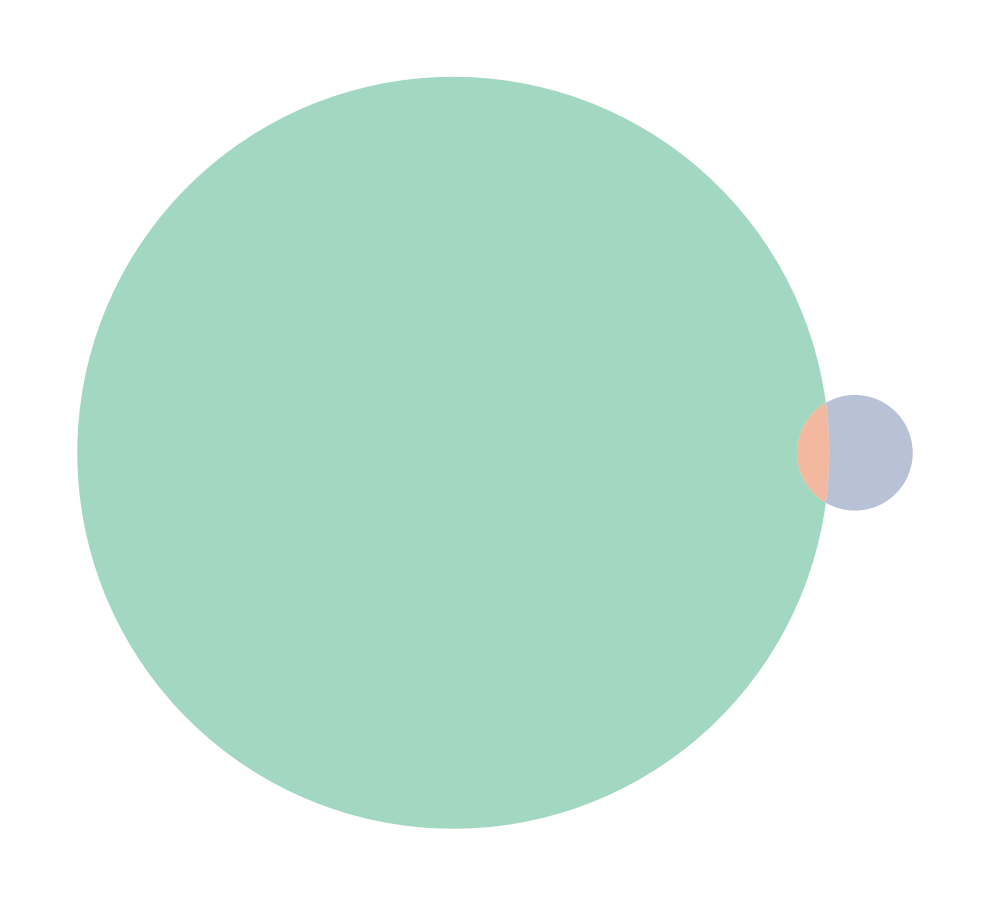

In [15]:
# Comparison with all assays
chemicals_in_assays = set(assay_df.chembl_id.unique())

plt.figure(figsize=(10, 10))

out = venn2(
    subsets=[chemicals_in_assays, phytochemicals], 
    set_labels=('', ''), #('ChEMBL', 'Plants'),
    set_colors=('#8BCEB2', '#a5b3ce'),
    alpha=.8,
)

out.get_patch_by_id('11').set_color('#efa888')
out.get_patch_by_id('11').set_edgecolor('none')

# remove labels
out.get_label_by_id('10').set_text('')
out.get_label_by_id('01').set_text('')
out.get_label_by_id('11').set_text('')

for text in out.subset_labels:
    text.set_fontsize(20)

plt.tight_layout()
plt.savefig('../figures/figure_4A.jpg', dpi=300)
plt.show()

# Comparison of medicinal and non-medicinal phytochemicals

In [16]:
bioactivity_summary = pd.DataFrame(columns=['Medicinal', 'Non-medicinal'], index=['Active', 'Inactive',])
bioactivity_summary.fillna(0, inplace=True)

In [17]:
med_active_cids = set()
med_inactive_cids = set()
non_med_active_cids = set()
non_med_inactive_cids = set()

for chembl_idx, _, pchem_val, _, active_flag in tqdm(bioassays.values):
    if active_flag:
        if chembl_idx in medicinal_phytochemicals:
            med_active_cids.add(chembl_idx)
        if chembl_idx in non_medical_phytochemicals:
            non_med_active_cids.add(chembl_idx)
    else:
        if chembl_idx in medicinal_phytochemicals:
            med_inactive_cids.add(chembl_idx)
        if chembl_idx in non_medical_phytochemicals:
            non_med_inactive_cids.add(chembl_idx)

bioactivity_summary.loc['Active', 'Medicinal'] = len(med_active_cids)
bioactivity_summary.loc['Inactive', 'Medicinal'] = len(med_inactive_cids)
bioactivity_summary.loc['Active', 'Non-medicinal'] = len(non_med_active_cids)
bioactivity_summary.loc['Inactive', 'Non-medicinal'] = len(non_med_inactive_cids)

100%|██████████| 11384/11384 [00:00<00:00, 263409.39it/s]


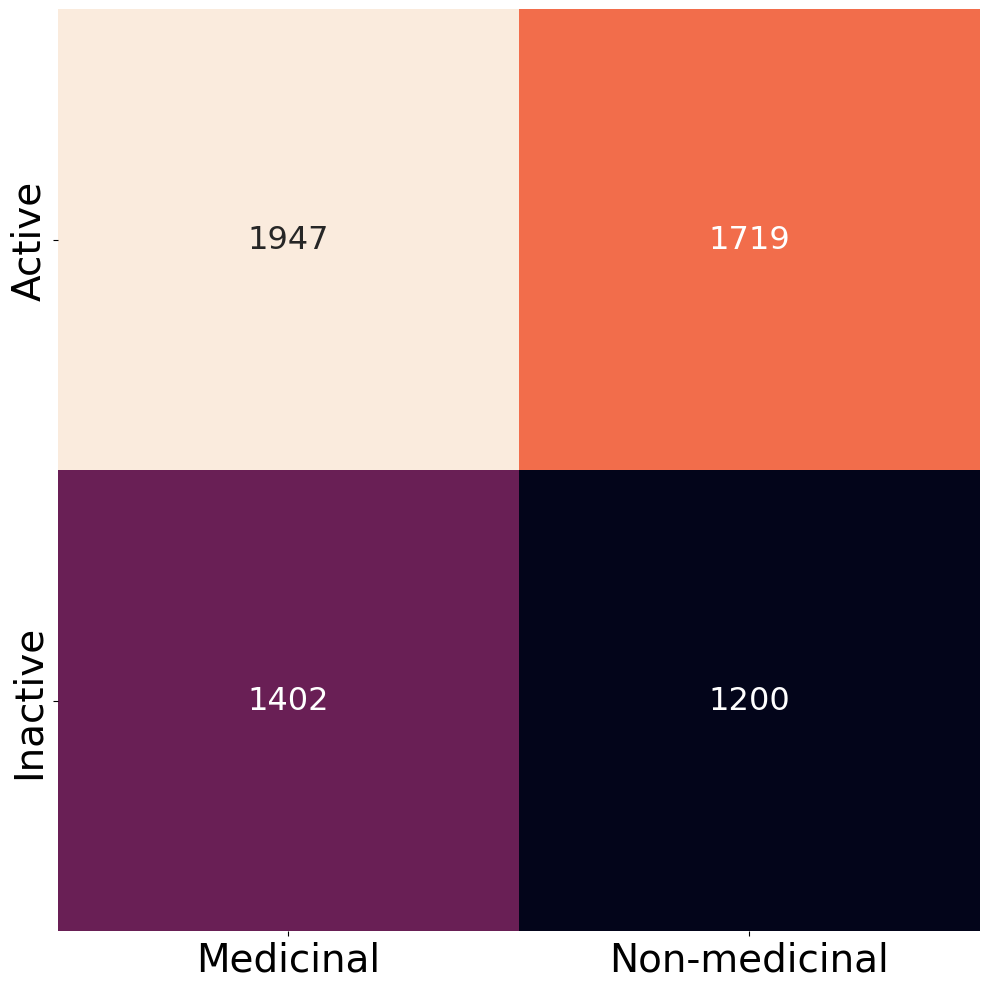

In [18]:
# Bioactivity comparison across medicinal and non-medicinal plants
plt.figure(figsize=(10, 10))
sns.heatmap(
    bioactivity_summary, cmap='rocket',
    annot=True, fmt='g', cbar=False,
    annot_kws={'fontsize': 23},
)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.tight_layout()
plt.savefig('../figures/figure_4B.jpg', dpi=300)
plt.show()


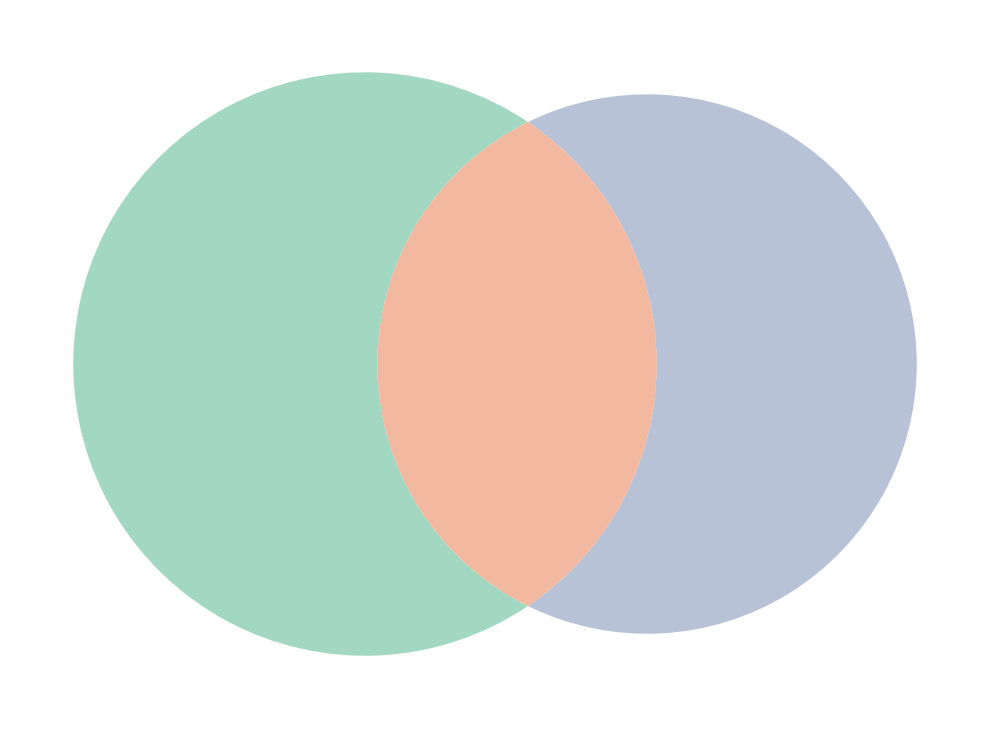

In [19]:
# Proportion of actives in medicinal and non-medicinal plants

active_chems = med_active_cids.union((med_inactive_cids - non_med_inactive_cids))
inactive_chems = non_med_active_cids.union((non_med_inactive_cids - med_inactive_cids))

plt.figure(figsize=(10, 10))

out = venn2(
    subsets=[active_chems, inactive_chems],
    set_labels=('', ''), # ('Medicinal', 'Non-medicinal'),
    set_colors=('#8BCEB2', '#a5b3ce'),
    alpha=.8,
)

out.get_patch_by_id('11').set_color('#efa888')
out.get_patch_by_id('11').set_edgecolor('none')

# remove labels
out.get_label_by_id('10').set_text('')
out.get_label_by_id('01').set_text('')
out.get_label_by_id('11').set_text('')

for text in out.subset_labels:
    text.set_fontsize(20)

plt.tight_layout()
plt.savefig('../figures/figure_4C.jpg', dpi=300)
plt.show()

# Annotating plant family information

In [20]:
# Time consuming step
genus_to_family, family_to_species = get_genus_and_family_info_for_plants(
    set(plant_chemical_df.plant_curie.unique())
)

ncbi = NCBITaxa()

order genus: 100%|██████████| 16884/16884 [00:00<00:00, 24495.51it/s]


# Statistical significance

In [21]:
fams = []
number_of_bioactive_plants = []
number_of_biactive_compounds = []

for fam_name, plants in tqdm(family_to_species.items()):
    t = set()
    k = set()

    for plant in plants:
        compounds = plant_chemical_df[plant_chemical_df.plant_curie == plant]['chembl_idx'].unique()
        bioactive_compounds = set(bioassays.loc[
            (bioassays.chembl_id.isin(compounds)) & (bioassays.active == True)
        ]['chembl_id'])

        if len(bioactive_compounds) < 1:
            continue

        t.add(plant)
        k.update(bioactive_compounds)

    if len(t) < 1 or len(k) < 1:
        continue

    number_of_bioactive_plants.append(len(t))
    number_of_biactive_compounds.append(len(k))
    fams.append(ncbi.get_taxid_translator([int(fam_name.split(':')[1])])[int(fam_name.split(':')[1])])

100%|██████████| 513/513 [08:09<00:00,  1.05it/s]  


In [22]:
genus = []
num_bioactive_plants = []
num_biactive_compounds = []

for genus_name, plants in tqdm(genus_to_family.items()):
    t = set()
    k = set()

    for plant in plants:
        compounds = plant_chemical_df[plant_chemical_df.plant_curie == plant]['chembl_idx'].unique()
        bioactive_compounds = set(bioassays.loc[
            (bioassays.chembl_id.isin(compounds)) & (bioassays.active == True)
        ]['chembl_id'])

        if len(bioactive_compounds) < 1:
            continue

        t.add(plant)
        k.update(bioactive_compounds)

    if len(t) < 1 or len(k) < 1:
        continue

    num_bioactive_plants.append(len(t))
    num_biactive_compounds.append(len(k))
    genus.append(ncbi.get_taxid_translator([int(genus_name.split(':')[1])])[int(genus_name.split(':')[1])])

100%|██████████| 4843/4843 [08:05<00:00,  9.98it/s]


In [23]:
fam_average_chemicals_per_species = sum(number_of_biactive_compounds) / sum(number_of_bioactive_plants)
fam_average_chemicals_per_species

1.2187714717603408

In [24]:
genus_average_chemicals_per_species = sum(num_biactive_compounds) / sum(num_bioactive_plants)
genus_average_chemicals_per_species

1.8898223385208648

Family chi-squared test

In [26]:
fam_count_df = pd.DataFrame(
    {'# plants': number_of_bioactive_plants, '# compounds': number_of_biactive_compounds, 'family': fams},
)
fam_count_df['expected'] = fam_average_chemicals_per_species * fam_count_df['# plants']
fam_count_df.head(2)

,# plants,# compounds,family,expected
0,4,5,Hernandiaceae,4.875086
1,31,37,Phyllanthaceae,37.781916


In [27]:
# defree of freedom for test
fam_count_df.shape[0]

382

In [28]:
chisquare(fam_count_df['# compounds'], fam_count_df['expected'])

Power_divergenceResult(statistic=3272.9736697359294, pvalue=0.0)

Genus chi-squared test

In [29]:
genus_count_df = pd.DataFrame(
    {'# plants': num_bioactive_plants, '# compounds': num_biactive_compounds, 'genus': genus},
)
genus_count_df['expected'] = genus_average_chemicals_per_species * genus_count_df['# plants']
genus_count_df.head(2)

,# plants,# compounds,genus,expected
0,2,3,Mercurialis,3.779645
1,15,11,Oryza,28.347335


In [30]:
genus_count_df.shape[0]

2717

In [31]:
chisquare(genus_count_df['# compounds'], genus_count_df['expected'])

Power_divergenceResult(statistic=8923.299829872074, pvalue=0.0)

# Overview of top 20 families

In [32]:
top_20_families = fam_count_df.sort_values(by=['expected'], ascending=False).head(20)
top_20_families.head(2)

,# plants,# compounds,family,expected
89,983,490,Asteraceae,1198.052357
97,807,515,Fabaceae,983.548578


In [33]:
t20_data = []

for plant_counts, compound_counts, fam_name, expected  in top_20_families.values:
    t20_data.append({
        'family': fam_name,
        'count': compound_counts,
        'type': 'Observed'
    })

    t20_data.append({
        'family': fam_name,
        'count': expected,
        'type': 'Expected'
    })

top_20_families = pd.DataFrame(t20_data)
top_20_families.head(2)

,family,count,type
0,Asteraceae,490.000000,Observed
1,Asteraceae,1198.052357,Expected


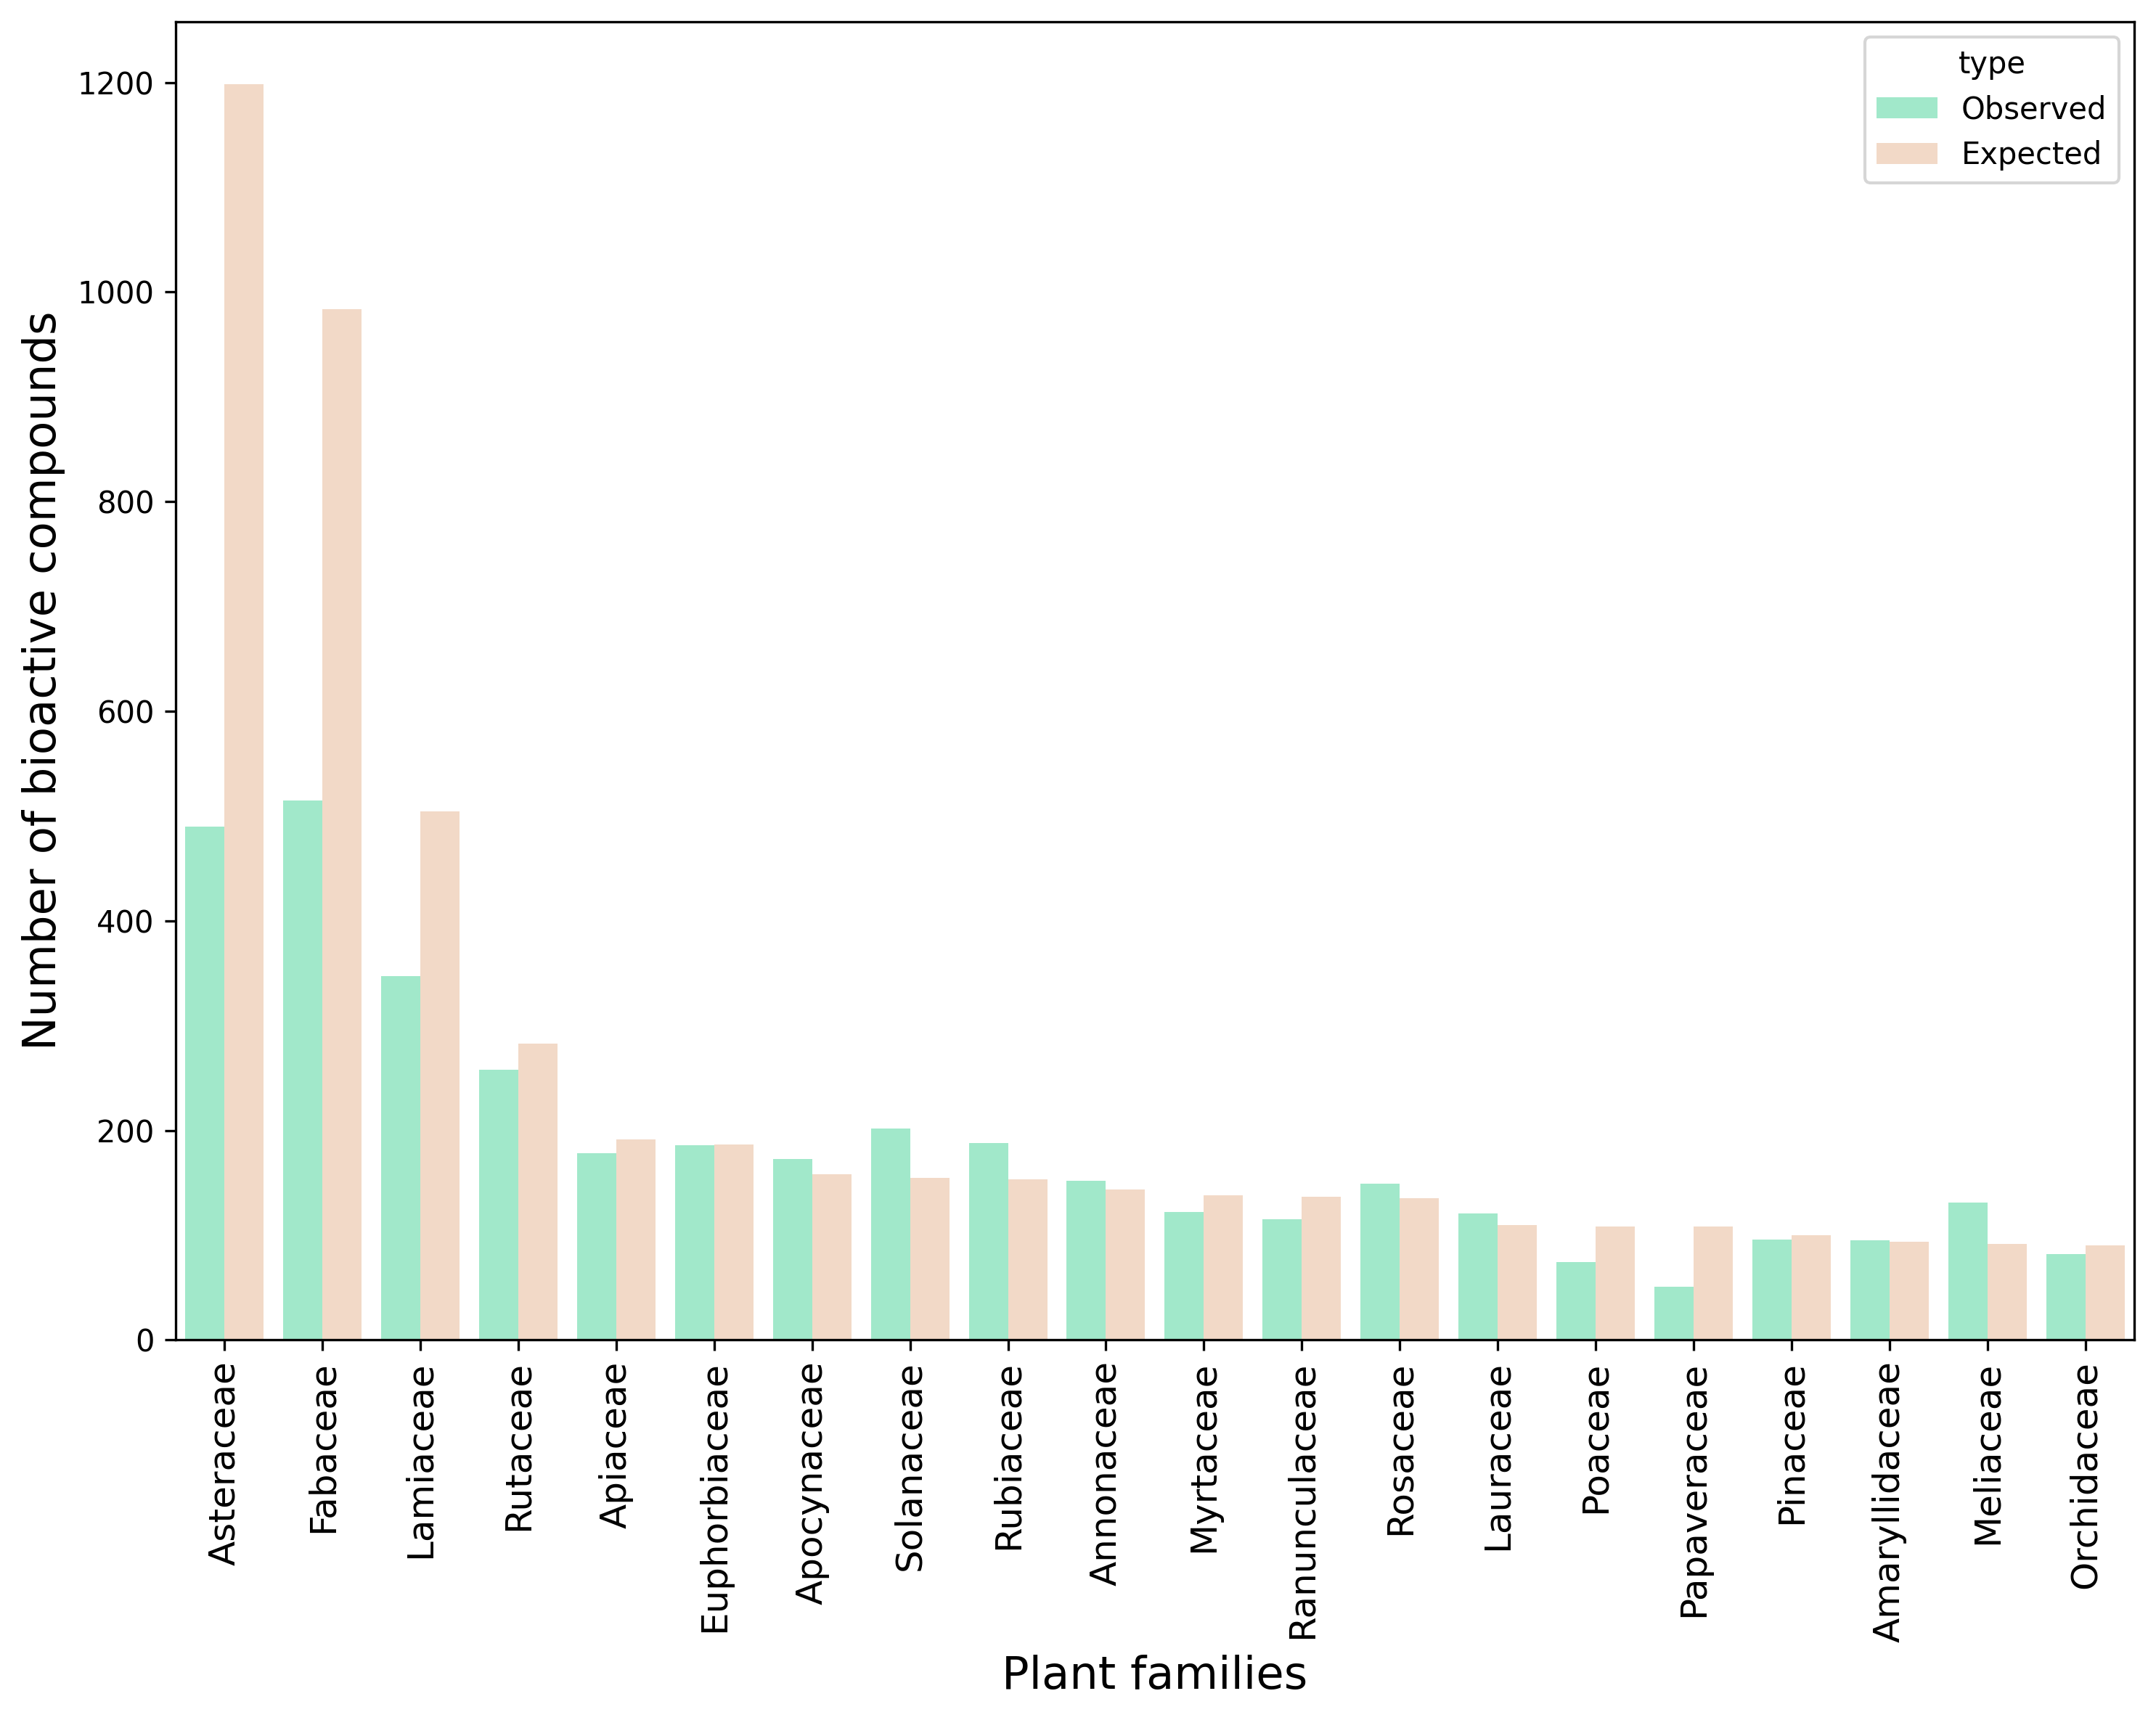

In [34]:
plt.figure(dpi=300, figsize=([10,8]))

sns.barplot(data=top_20_families, x='family', y='count', hue='type', palette={
        "Observed": '#2dea99',
        'Expected': '#f4b183',
    }, alpha=0.5)
plt.xticks(rotation=90, fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Plant families', fontsize=15)
plt.ylabel('Number of bioactive compounds', fontsize=15)
plt.tight_layout()
plt.savefig('../figures/supplementary_figure_5.png', bbox_inches='tight')

plt.show()